# EDA

### Import der benötigten Pakete

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

### Einlesen der CSV-Dateien

In [2]:
# Funktion zum Einlesen
def csv_to_df(csv):
    df = pd.read_csv(csv, header=0, sep=';', quotechar='"', decimal=',', low_memory=False)
    return df

# Produkte
product = csv_to_df("../data/origin/PRODUCT.csv")
product.name = "Produkte"

# Hersteller
company = csv_to_df("../data/origin/COMPANY.csv")
company.name = "Hersteller"

# Hersteller-Adresse
company_adress = csv_to_df("../data/origin/COMPANYADDRESS.csv")
company_adress.name = "Hersteller-Adresse"

# Schnittstelle Hersteller u. Produkt
product_company = csv_to_df("../data/origin/PRODUCT_COMPANY.csv")
product_company.name = "API-Produkt-Hersteller"

# Interaktionen
interaction = csv_to_df("../data/origin/INTERACTION.CSV")
interaction.name = "Interaktionen"

# Interaktions-Klasse
interaction_class = csv_to_df("../data/origin/INTERACTION_CLASS.csv")
interaction_class.name = "Interaktionsklasse"

# Schnittstelle zw. Produkte u. Interaktionen
product_interaction_class = csv_to_df("../data/origin/PRODUCT_INTERACTION_CLASS.csv")
product_interaction_class.name = "API-Produkte-Interaktionen"

### Bereinigung der Dataframes auf die relevanten Spalten

In [3]:
# Produkte (hier reicht die ID, der Name und als zusätzl. Info das Markteintrittsdatum)
product = product[['ID','NAME','ONMARKETDATE']]

# Hersteller (ID, Name)
company = company[['ID','NAME']]

# Hersteller-Adresse (ID, COMPANYID, ZIP, STREET, STREETNUMBER)
company_adress = company_adress[['ID', 'COMPANYID', 'ZIP', 'CITY', 'STREET', 'STREETNUMBER']]

# Schnittstelle zw. Produkte und Hersteller
product_company = product_company[['PRODUCTID', 'COMPANYID']]

# Interaktionen (ID, Interaktionsklasse1, Interaktionsklasse2, Severity, Likelihood)
interaction = interaction[['INTERACTIONCLASSID1', 'INTERACTIONCLASSID2', 'SEVERITY', 'LIKELIHOOD']]

## Produkt / Arzneimittel

<b>Offene Fragen:</b>
1. Betrachtung über den Zeitraum: 
    - Wann kamen die meisten Produkte auf den Markt
    - Durchschnittle Zahlen und Marktwachstum
2. Art der Produkte
    - Welche Art von Produkten gibt es?
    - Welche davon stechen heraus?

In [4]:
# Anpassen des Datums bei ONMARKETDATE in product --> MySQL arbeitet mit amerikanischem Datumsformat
product['ONMARKETDATE'] = pd.to_datetime(product['ONMARKETDATE'], format='%d.%m.%Y')

In [5]:
product_eda = product #eigenes DF für Analysezweck
product_eda['ONMARKETDATE'] = product_eda['ONMARKETDATE'].dt.year #Datum auf Jahr beschränken
product_eda = product_eda.groupby(product_eda['ONMARKETDATE'])['ID'].agg(['count']) #Nach Jahr gruppieren und aufsummieren
product_eda = product_eda.drop(2019) # Jahr 2019 entfernen
product_eda.tail() #Ausgabe zur Überprüfung

,count
ONMARKETDATE,
2014,31944
2015,29774
2016,47895
2017,89669
2018,94006


In [6]:
product_eda.columns = ['Arzneimittel'] #Neue Spalte umbenennen
# Wann kamen wie viele Medikmante auf den Markt?
product_eda.sort_values(by='Arzneimittel', ascending=False).head(10)

,Arzneimittel
ONMARKETDATE,
2018,94006
2017,89669
2016,47895
2014,31944
2015,29774
2012,27824
2004,26952
2013,19676
2011,19169


       Arzneimittel
count     82.000000
mean    6369.682927
std    16329.984554
min        1.000000
25%       11.000000
50%       46.500000
75%     2338.250000
max    94006.000000


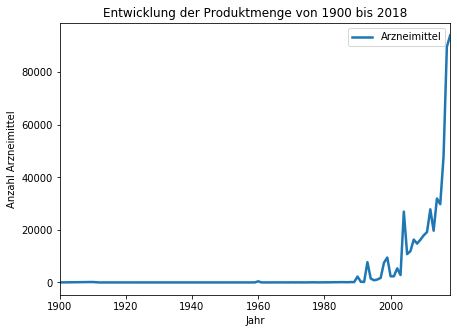

In [7]:
product_plot = product_eda.plot(linewidth=2.5, figsize=(7,5))
product_plot.set(ylabel='Anzahl Arzneimittel',
            xlabel='Jahr', title='Entwicklung der Produktmenge von 1900 bis 2018')

print(product_eda.describe())

In [8]:
# Anpassen des Datums bei ONMARKETDATE in product --> MySQL arbeitet mit amerikanischem Datumsformat
product['ONMARKETDATE'] = pd.to_datetime(product['ONMARKETDATE'], format='%d.%m.%Y')

product_eda_2 = product #eigenes DF für Analysezweck
product_eda_2['ONMARKETDATE'] = product_eda_2['ONMARKETDATE'].dt.month #Datum auf Jahr beschränken
#Nach Jahr gruppieren und aufsummieren
product_eda_2 = product_eda_2.groupby(product_eda_2['ONMARKETDATE'])['ID'].agg(['count']) 

ValueError: time data '1977' does not match format '%d.%m.%Y' (match)

In [ ]:
product_eda_2.rename(columns={'count':'Anzahl'})
product_eda_2.reset_index()

In [ ]:
monate = ('Januar','Februar','März','April','Mai','Juni','Juli','August','September','Oktober','November','Dezember')
product_eda_2['Monat'] = monate
plot = product_eda_2.plot.line(y='Anzahl', x='Monat', linewidth=2.5, xticks=range(0, 12), figsize=(12,5), style='o-')

plot.set(ylabel='Anzahl Arzneimittel',
            xlabel='Monat', title='Aufsummierte Gesamtmenge an veröffentlichten Produkten pro Monat')

### Welche Arten von Produkten gibt es?

1. Untersuchung der Produktnamen anhand einer Wordcloud

In [ ]:
# 1. WordCloud
text = " ".join(word for word in product.NAME)

# Stopwords anlegen
stopwords = set(STOPWORDS)
stopwords.update(['mg','ml','einer','zur','Anwendung','mg','Einheit','Herstellung','Sp','sch','VTimp','HRW','schwarz',
                'subkutanen','forte','DHU','mediven','CCL1','CCL2','eleg','JUZO','BELSANA','comf','KKL2','Fuß',
                'COMPRESSANA','kurz','mit','AG','ohne','kompr','Gudjons','plus','SPIRIT','CCL3','LT','K2','groß',
                'AD','SP','K2','pet','SOFT','JOBST','NHB','medi','magenta','ELEG','DYNAMIC','K1','sensitiv','Hüftb',
                'K1','AGK','EHB','REG','SPITZE','laftofa','kkl','sigvaris','VenoTrain','balancehr','KL1','HRW','vet',
                'Spagyros','Dilution','SoSp','LM','SPRINg','NoB','pl','Fuss','Haftrand','Motiv','5cm','NoM','CL',
                'Wala','ku','MfB','MOTIV','BALANCEHAFTR','WEIT','Fo','la','OSP','GR','MAGIC','AGEK','TBs','BW','ca',
                'Staufen','LEGANZA','KL2','FINO','TBp','vg','TBe','TBb','6cm','KKL1','mv','SCHM','DHBM','Sp6','mode',
                'Maxis','Micro','CC Pharma','Micro CCL','DE LUXE','HbdNg','VTsof','BALANCEHAFTRAND','SCHMAL','Sp2',
                'DELUXE','CC','Pharma','Ecosana','Comfort','DE','LUXE','SPH','CHR','VENEX','DUR','ge','und','CCL',
                'duomed','basic','gFS','HbdNo','oFS','Lastofa','SHB','DYNAM','Suprima','gF','cm','NHBM','SSklFu',
                'Marine','klei','sw','oS','rose','amp','Sp4','HRMW','cara','VIOL','VENESSO','HBF','AGH','Venosan',
                'Inkontinenzhose','XXL','Kortikalis','GPH','Solus','cashmere','Sp3','K3','Sp7','LPS','HR','K2MS',
                'SILK','Mepilex','Opaque1','Noppe','Monofil','hrm','spagyra','ureterschiene','nova','haemato',
                'linea','blau','grün','rot','bronze','orange','gelb','mondscheinblau','pink','BB','Hauschka','AGKK',
                'Hyphen','fashy','Homeda','elegance','ho','Komplex','Roche','zum','sand','Anthroposan','black',
                'NHR','Junek','eco','TRACOE','Screw','anth','CCL2AT','anthrazit','XL','large','SILHB','m','Sp5',
                '2','1','o','M','Spitze','AT','5','3','Gr.','sigvaris','comfort','SIGVARIS','marine','Ccl2',
                'Rose','INSPIRATION','SCHWARZ','SENSITIV','SANDEL','PFEFFER','Ccl1','für','HAFTRAND','100','plus'])

# WordCloud generieren
wordcloud = WordCloud(
    max_words = 60,
    colormap = "Blues",
    width = 1600,
    height = 900,
    background_color = 'white',
    stopwords = stopwords).generate(str(text))

#Plotten
fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'w',
    edgecolor = 'w')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
# Frequenz der vorkommenden Wörter in Zahlen:
text_one = text.split()
text_two = list(stopwords)

text_final = [item for item in text_one if item not in text_two]

In [ ]:
text_df = pd.DataFrame(text_final)
text_df.columns = ['Wort']

# Filtern auf Wörter, die mehr als drei Buchstaben aufweisen 
text_df = text_df[text_df['Wort'].map(len) > 2]

# Ausgabe der Frequenz jedes Wortes, sortiert nach absteigender Häufigkeit
print('Wortfrequenzen:')
pd.Series(' '.join(text_df['Wort']).split()).value_counts()[:10]

### Weitere Werte:

In [ ]:
print('Durchschn. Anzahl der Arzneimittel pro Jahr seit dem Jahr 2000:\n' + str(product_eda.tail(19).mean())) 
print('Marktwachstum im Mittel seit 2000:\n' + str(product_eda['Arzneimittel'].pct_change().tail(19).mean()))

## Hersteller-Adresse

<b>Offene Fragen:</b>
1. In welchem Bundesland sind die Hersteller angesiedelt?
2. Aus welcher Stadt stammen die meisten Hersteller?
3. Wie sind die Unternehmen verteilt (Map-Ansicht Deutschland)
4. Wie viele Städte enthält der Datensatz?

In [ ]:
cmp_ad_eda = company_adress[['ID','CITY']] # eigenes DF für Analysezweck
cmp_ad_eda = cmp_ad_eda.groupby('CITY').count().sort_values(by='ID', ascending=False)
cmp_ad_eda.columns = ['Anzahl Hersteller'] # Umbenennen der Ergebnisspalte
print('Anzahl Hersteller in einer Stadt:')
print(cmp_ad_eda.describe())
cmp_ad_eda.head(10).plot.barh()
cmp_ad_eda.head(10)

In [ ]:
# Datenpfad für Deutschland-Map mit PLZen
fp = "../data/maps/plz-gebiete.shp"
map_df = gpd.read_file(fp)

# Einlesen von PLZ-File
plz = pd.read_csv('../data/maps/plz-gebiete.csv', header=0, dtype={'plz': object})

# Merge von SHP-File und PLZ-File
merge_one = pd.concat([map_df, plz], axis=1)
# Überprüfen, ob Map geladen werden kann
merge_one.info()
print(merge_one.head(10))

In [ ]:
# DF für Städte mit der Postleitzahl
cmp_plz = company_adress[['ID', 'ZIP']]
cmp_plz = cmp_plz.groupby('ZIP').count().sort_values(by='ID', ascending=False) # Gruppieren nach PLZ
cmp_plz.columns = ['Anzahl'] # Umbenennung der Ergebnisspalte
cmp_plz = cmp_plz.reset_index()
cmp_plz.info()
cmp_plz.head()

In [ ]:
#Merge von Choropleth-Map und PLZ-DF
merge_two = pd.merge(merge_one, cmp_plz, left_on='plz', right_on='ZIP', how='left')
merge_two = merge_two.drop('ZIP', 1) # PlZ nach Merge doppelt enthalten --> Drop
merge_two = merge_two.fillna(0)
merge_two.Anzahl = merge_two.Anzahl.astype(int)
merge_two.head()

In [ ]:
# Variable zur Festlegung der anzuzeigenden Spalte
variable = 'Anzahl'
# Range der Map
vmin, vmax = 1, 174
# Figur und Axen deklarieren
fig, ax = plt.subplots(1, figsize=(10, 6))

# Erstellen der Map
merge_two.plot(column=variable, cmap='Blues', linewidth=0.3, ax=ax, edgecolor='0.8')

# Titel
ax.set_title('Aufteilung der Hersteller nach PLZ', fontdict={'fontsize': '14', 'fontweight' : '2'})
# Annotation
ax.annotate('Quelle für Map: suche-postleitzahl.org',xy=(0.3, .08),  xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Axen ausblenden
ax.axis('off')

# Colorbar als Legende einfügen
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# Leeres Array für Daten-Range
sm._A = []
# Colorbar hinzufügen
cbar = fig.colorbar(sm)
fig.savefig('map_comp_plz', dpi=300)

In [ ]:
# Datenpfad für Deutschland-Map mit 1stelliger PLZ
fp2 = "../data/maps/GermanyPolygon21.shp"
map2_df = gpd.read_file(fp2)

# Einlesen von Bundesland-File
states = pd.read_csv('../data/maps/states.csv', header=0)
states.info()

# Merge von SHP-File und PLZ-File
merge_three = pd.concat([map2_df, states], axis=1)
merge_three.head()


In [ ]:
# Einlesen von Zuordnungstabelle von PLZ zu Bundesländern
zip_to_states = pd.read_csv('../data/maps/zip_to_states.csv', header=0, sep=';', dtype={'PLZ': object})

# Neues DF für diese Analyse aus ID und PLZ der Hersteller-Adresse-Tabelle
cmp_eda2 = company_adress[['ID', 'ZIP']]

# Merge von Hersteller-Adresse und Bundesland
merge_four = pd.merge(cmp_eda2, zip_to_states, left_on="ZIP", right_on="PLZ")
merge_four = merge_four.drop(['ZIP', 'PLZ'], axis=1) # PLZen werden nicht weiter benötigt

# Count für die Bundesländer
merge_four = merge_four.groupby('Bundesland').count().sort_values(by='ID', ascending=False) # Gruppieren nach PLZ
merge_four.columns = ['Anzahl'] # Umbenennung der Ergebnisspalte
merge_four = merge_four.reset_index()
merge_four

In [ ]:
#Merge von Choropleth-Map und Bundesland-DF
merge_five = pd.merge(merge_three, merge_four, left_on='Bundesland', right_on='Bundesland', how='left')
merge_five = merge_five.drop('Bundesland', 1) # PlZ nach Merge doppelt enthalten --> Drop
merge_five.Anzahl = merge_five.Anzahl.astype(int)
print(merge_five.describe())
merge_five.head()

In [ ]:
# Variable zur Festlegung der anzuzeigenden Spalte
variable2 = 'Anzahl'
# Range
vmin, vmax = 8, 798
# Figure anlegen
fig, ax = plt.subplots(1, figsize=(10, 6))

# Erstellen der Map
merge_five.plot(column=variable, cmap='Blues', linewidth=0.4, ax=ax, edgecolor='0.8')

# Titel
ax.set_title('Aufteilung der Hersteller nach Bundesland', fontdict={'fontsize': '14', 'fontweight' : '2'})
# Annotation
ax.annotate('Quelle für Map: https://www.igismap.com',xy=(0.3, .08),  xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Axen ausblenden
ax.axis('off')

# Colorbar als Legende einfügen
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# Leeres Array für die Daten-Range
sm._A = []
# Colobar
cbar = fig.colorbar(sm)

# Speichern der Grafik
fig.savefig("map_comp_states.png", dpi=300)

## Produkt-Hersteller
<b>Offene Fragen:</b>
1. Welcher Hersteller stellt die meisten Arzneimittel her?
2. Wie viele Arzneimittel hat ein Hersteller im Durchschnitt auf dem Markt?
3. Gibt es Hersteller, die kaum noch aktiv sind? (Kombination aus Markteintrittsdatum und Hersteller)

In [ ]:
# Merge aus den Produkten und Herstellern
prod_comp_merge = pd.merge(product, product_company, left_on='ID', right_on='PRODUCTID')
prod_comp_merge = prod_comp_merge.drop('PRODUCTID', 1) # PRODUCTID nach Merge doppelt enthalten --> Drop
# Hersteller dem jeweiligen Produkt zuweisen
prod_comp_merge2 = pd.merge(prod_comp_merge, company[['ID','NAME']], left_on="COMPANYID", right_on="ID")
prod_comp_merge2 = prod_comp_merge2[['ID_x','NAME_x','ONMARKETDATE','NAME_y']] # Doppelte Spalten entfernen
prod_comp_merge2.columns = ['ID','Arzneimittel','Markteintrittsdatum','Hersteller'] #Spaltenumbenennung
prod_comp_merge2 = prod_comp_merge2.sort_values(by='ID', ascending=True) # Sortierung nach ID aufsteigend

In [ ]:
prod_comp_merge2.head()

In [ ]:
prod_comp_merge3 = prod_comp_merge2[['ID','Hersteller']]
prod_comp_merge3 = prod_comp_merge3.groupby('Hersteller').count().sort_values(by='ID', ascending=False)
prod_comp_merge3.columns = ['Anzahl'] # Umbenennung der Ergebnisspalte
print(prod_comp_merge3.describe())
print(prod_comp_merge3.head(10))
plot = prod_comp_merge3.head(10).sort_values(by='Anzahl').plot.barh()
plot.set(title='Die zehn größten Hersteller von Arzneimitteln',
        ylabel='')

Anzahl der Hersteller die nur wenige Produkte herstellen:

In [ ]:
prod_comp_merge3.head(10)

### Zeitverlauf: Die aktivsten Hersteller in den letzten Jahren

In [ ]:
prod_comp_time = prod_comp_merge2[['ID','Markteintrittsdatum', 'Hersteller']]

# Drop a row by condition
prod_comp_time = prod_comp_time[prod_comp_time.Markteintrittsdatum >= 2009]
prod_comp_time.groupby(['Hersteller','Markteintrittsdatum']).count()['ID'].unstack()
#prod_comp_time.groupby(['Hersteller']).count().reset_index().sort_values(by='Markteintrittsdatum', ascending=False)

## Interaktionen
<b>Offene Fragen:</b>
1. Welche Wirkstoffe generieren am häufigsten Wechselwirkungen?
2. Weche Wirkstoffe generieren am wenigsten Wechselwirkungen?
3. Schweregradanalyse (Was kommt am häufigsten vor, was selten etc.)
4. Wahrscheinlichkeitsanalyse

In [ ]:
# Anlegen eines DF eigens für diese Untersuchung
interaction_eda = interaction
# Head anzeigen
interaction.head()

Ausprägung der Spalten SEVERITY und LIKELIHOOD

Ergebnis: 
- Jede der Spalten beinhaltet vier einzigartige Ausprägungsmöglichkeiten
- Der Schwierigkeitsgrad 'mittelschwer' kommt am Häufigsten vor (in 4325 von 7619 Fällen - 57 %)
- Die Wahrscheinlichkeit 'Begrenz untersucht' kommt am Häufigsten vor (in 2973 von 7619 Fällen - 39 %)

In [ ]:
print(str(interaction_eda.SEVERITY.describe()) + '\n' + '----'+ '\n'+ str(interaction_eda.LIKELIHOOD.describe()))

# Grafische Veranschaulichung
interaction_eda.SEVERITY.value_counts().plot.pie(
    startangle=60,
    autopct='%1.1f%%',
    fontsize=12,
    title='Welchen Schweregrad haben die Interaktionen?',
    colors=('#5288DB', '#73C2FB','#0080FF','#7285A5'))
plt.tight_layout()
plt.show()

In [ ]:
interaction_eda.LIKELIHOOD.value_counts().plot.pie(
    startangle=55,
    autopct='%1.1f%%',
    fontsize=12,
    title='Inwieweit sind die Interaktionen untersucht?',
    colors=('#5288DB', '#73C2FB','#0080FF','#7285A5'))
plt.tight_layout()
plt.show()

Interessant ist zudem, wie gut die jeweils einzelnen Interaktionenstypen untersucht sind.

Ergebnis:
- Die schwerwiegenden und mittelschweren Interaktionen sind größtenteils nur begrenzt untersucht oder gar nicht erwiesen.
- Generell sind die wenigstens Interaktionen überhaupt sehr gut untersucht.

In [ ]:
interaction_eda_2 = interaction_eda.groupby(['SEVERITY','LIKELIHOOD']).count()['INTERACTIONCLASSID1'].unstack()
interaction_eda_2.head()

In [ ]:
interaction_eda_2 = interaction_eda_2[['Nicht erwiesen','Begrenzt untersucht.','Gut untersucht.','Sehr gut untersucht.']]
interaction_eda_2.head()

interaction_eda_2.plot.barh(stacked=True,
                           colors=('#8D021F', '#ED2939','#0080FF','#73C2FB') )

#### Welche Interaktionsklassen weißen am meisten Wechselwirkungen auf und welche Interaktionsklassen sind am häufigsten schwerwiegend oder mittelschwer?

Prequisite: Merge aus Interaktionsklassen und Interaktionen, um die Namen der Interaktionsklassen aufzeigen zu können.

In [ ]:
# Merge aus Interaktionsklassen und Interaktionen
interaction_eda_3 = pd.merge(interaction, interaction_class, left_on='INTERACTIONCLASSID1',
    right_on='INTERACTIONCLASSID')

interaction_eda_4 = interaction_eda_3.groupby('NAME').count()['INTERACTIONCLASSID2']
interaction_eda_4 = interaction_eda_4.to_frame()
interaction_eda_4.columns = ['Anzahl Interaktionen']

# Wie viele Interaktionen weist eine Interaktionsklasse im Schnitt auf?
interaction_eda_4.describe()

#### Welche Interaktionsklassen haben/verursachen die meisten Wechselwirkungen?

In [ ]:
interaction_eda_4 = interaction_eda_4.reset_index()
interaction_eda_4.columns = ['Wirkstoff', 'Anzahl Interaktionen']
interaction_eda_4.sort_values(ascending=False, by='Anzahl Interaktionen').head(10)

#### In welchen Schweregrad-Klassen sind welche Wirkstoffe besonders dominant?

In [ ]:
interaction_eda_3.head()
interaction_eda_5 = interaction_eda_3[['SEVERITY','INTERACTIONCLASSID2', 'LIKELIHOOD','NAME']]

kategorienliste = ('schwerwiegend', 'mittelschwer', 'geringfügig', 'Vorsicht')

# For-Schleife, um jede Kategorie zu durchlaufen
for kategorie in kategorienliste:
    print(interaction_eda_5[interaction_eda_5.SEVERITY == kategorie].groupby(['SEVERITY',
            'NAME']).size().sort_values(ascending=False).head())

## Produkt-Interaktion
<b>Offene Fragen:</b>
1. Welches Produkt hat am meisten Interaktionsklassen
2. Durchschnittliche Anzahl von Interaktionsklassen pro Produkt
3. Welche Interaktionsklasse hat am meisten Verknüpfungen zu Produkten
4. Welche Produkte sind am gefährlichsten? (Aufbauend auf der Analyse der gefährlichsten Wirkstoffe)

#### Produkt mit den meisten Interaktionsklassen (meisten enthaltenen Wirkstoffe)

Zunächst muss das Produkt-Interaktionen-DF mit dem Produkt DF gemerged werden:

In [17]:
# Merge aus Produkt-Interaktionen und Produkten
prod_inter_eda = pd.merge(product_interaction_class, product, left_on='PRODUCTID',
    right_on='ID')

# Für die Analyse ausreichend sind die Interaktionsklasse und der Name des Produkts
prod_inter_eda = prod_inter_eda[['INTERACTIONCLASSID','NAME']]
prod_inter_eda_2 = prod_inter_eda

prod_inter_eda = prod_inter_eda.groupby(['NAME']).count().sort_values(by='INTERACTIONCLASSID', ascending=False)
prod_inter_eda.columns = ['Anzahl'] # Umbenennung der Ergebnisspalte
prod_inter_eda.head(10)

,Anzahl
NAME,
"Olimel 4,4 % E Emulsion zur Infusion, 2000 ml + Cernevit, Set",29
"Olimel 5,7 % E Emulsion zur Infusion, 2000 ml + Cernevit, Set",29
"Olimel 5,7 % E Emulsion zur Infusion, 1500 ml + Cernevit, Set",29
"Olimel 5,7 % E Emulsion zur Infusion, 1000 ml + Cernevit, Set",29
"Olimel 4,4 % E Emulsion zur Infusion, 1500 ml + Cernevit, Set",29
"Olimel 4,4 % E Emulsion zur Infusion, 1000 ml + Cernevit, Set",29
Arelix® ACE 5 mg/6 mg Tabletten,24
Cernevit + Addel Trace (Mikronährstoff-Set) Kombipackung,23
"Irbesartan HCTZ Fair-Med 150+12,5 mg Filmtabletten",20


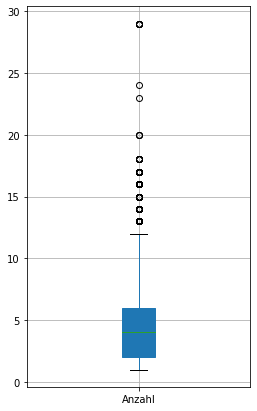

In [18]:
# Darstellung der Verteilung als Boxplot
prod_inter_eda.boxplot(patch_artist=True,figsize=(4,7))

In [19]:
# Tabellarische Darstellung
prod_inter_eda.describe()

,Anzahl
count,32663.000000
mean,4.370235
std,2.707902
min,1.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,29.000000


Ergebnis 1: 
 - Die meisten Wirkstoffe beinhaltet das Produkt Olimel 5,7 % E Emulsion zur Infusion
 - Boxplot zeigt Verteilungen
 - Im Durchschnitt haben Medikamente rund vier Wirkstoffe
 - Maximum bei 29
 - 25%-Quantil bei 2, Median bei 4, 75%-Quantil bei 6

#### Welche Interaktionsklassen/Wirkstoffe tauchen am häufigsten in den Produkten auf?

Merge aus vorherigem DF und den Interaktionsklassen

In [22]:
# Merge aus Interaktionsklassen und Interaktionen
prod_inter_eda_2 = pd.merge(prod_inter_eda_2, interaction_class)
prod_inter_eda_2 = prod_inter_eda_2[['NAME','INTERACTIONCLASSID']]
prod_inter_eda_2.head()


prod_inter_eda_2 = prod_inter_eda_2.groupby(['NAME']).count().sort_values(by="INTERACTIONCLASSID", ascending=False)
prod_inter_eda_2.columns = ['Anzahl'] # Umbenennung der Ergebnisspalte
prod_inter_eda_2.head(10)

,Anzahl
NAME,
Oral verabreichte Arzneimittel,23030
"Arzneimittel, Bradykinin und Angioödem",4370
Arzneimittel zur Senkung des arteriellen Blutdrucks,3030
Sedativa,2996
Substanzen mit Risiko für CYP3A4,2450
Kaliumsenkende Arzneimittel,1923
Antipsychotika,1609
Angiotensin II Antagonisten,1497
Angiotensin-II-Rezeptor-Antagonisten,1497


In [23]:
prod_inter_eda_2.reset_index().describe()

,Anzahl
count,1161.000000
mean,122.950043
std,724.363670
min,1.000000
25%,8.000000
50%,28.000000
75%,89.000000
max,23030.000000


Ergebnis 2: 
- Sehr interessante Darstellung, da hierbei auffällt, dass es sehr viele Wirkstoffgruppen gibt. Außerdem liefern diese sogar weitere Informationen wie z.B. die Art und Weise der Einnahme oder die genaue Funktion/Wirkungen des Präparats.

#### Wie viele Medikamente aus dem Gesamtdatensatz erzeugen überhaupt Wechselwirkungen?

Das Produkt-Interaktion DataFrame hat deutlich weniger Zeilen als das Produkt-DF. Ein Großteil der Medikamente erzeugt also gar keine Wechselwirkungen! Dies gilt es zu untersuchen.